# Other Clustering Approaches

In [2]:
import glob
import re

import pandas as pd

stats = glob.glob("/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/*stats.txt")

def parse_stats_file(file_path):
    df = []
    with open(file_path) as f:
        first_line = f.readline().strip()
        pval = float(first_line.split()[-2])
        tstat = float(first_line.split()[-1])
        for line in f:
            line = line.strip().split("\t")
            df.append(line[1:])
    return pval, tstat, pd.DataFrame(df)

def parse_stats_name(file_path):
    return re.match("/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_(.*)_stats.txt", file_path).group(1)

def get_clusters(file_path):
    clusters = []
    name = parse_stats_name(file_path)
    cfi_path = f"/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_{name}_clusters.txt"
    with open(cfi_path) as f:
        for line in f:
            clusters.append(line.strip().split("\t"))
    return clusters


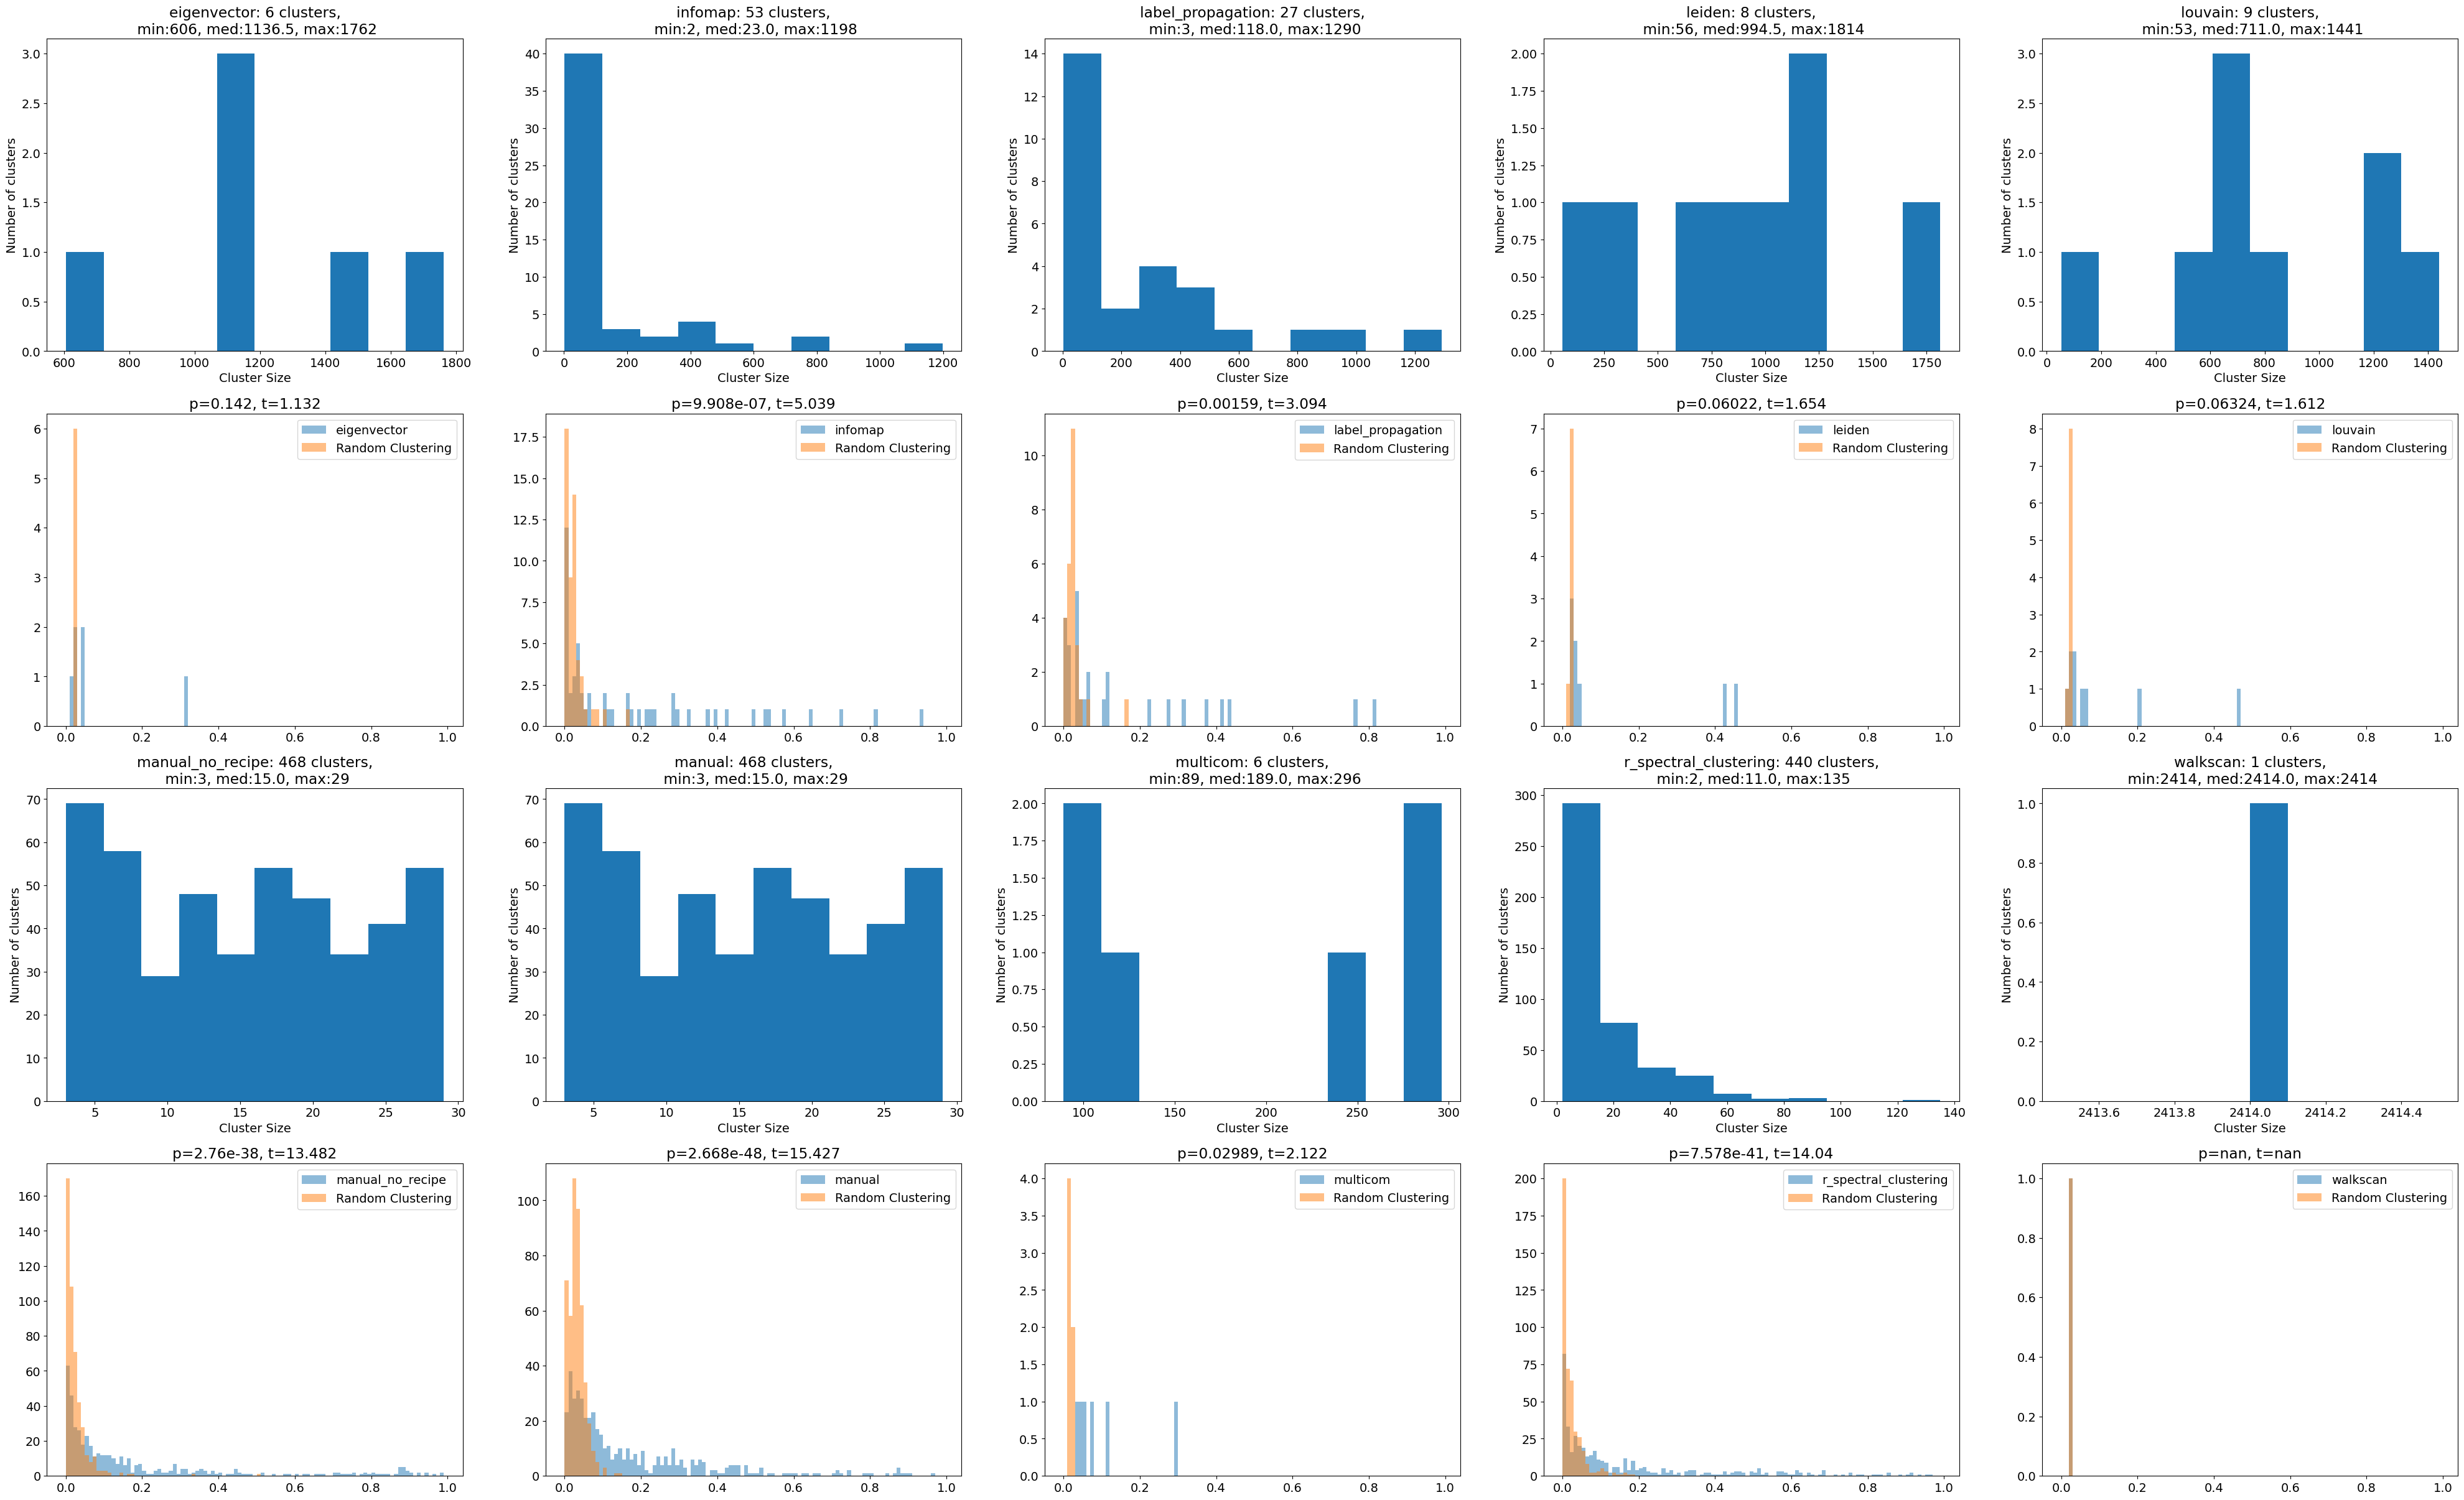

In [30]:
import matplotlib.pyplot as plt
import numpy as np

ax_columns = 5
ax_rows = 2 * (len(stats) // ax_columns)
stats = [i for i in stats if i != "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_stats.txt"]

fig,ax = plt.subplots(ax_rows,ax_columns, figsize=(50,30))
plt.rcParams.update({'font.size': 14})

for i, fi in enumerate(sorted(stats)):

    row = (i // ax_columns) * 2
    column = i % ax_columns
    fi_stem = fi.split('/')[-1]

    try:
        name = parse_stats_name(fi)
        # print(row, column, name)
    except AttributeError:
        ax[row,column].set_title(f"Error parsing\n{fi_stem}")
        # print(f"{row} {column} {fi_stem}")
        continue
    pval, tstat, df = parse_stats_file(fi)
    # print(f"{name}: {pval}, {tstat}")

    try:
        clusters = get_clusters(fi)
        lengths = np.array([len(c) for c in clusters])
        med_length = np.median(lengths)
        min_length = np.min(lengths)
        max_length = np.max(lengths)
        n_clusters = len(clusters)
        ax[row,column].hist(lengths)
        ax[row,column].set_xlabel("Cluster Size")
        ax[row,column].set_ylabel("Number of clusters")
        ax[row,column].set_title(f"{name}: {n_clusters} clusters,\n min:{min_length}, med:{med_length}, max:{max_length}")

    except FileNotFoundError:
        ax[row,column].set_title(f"{name}: No cluster file")

    method_scores = df[df[0] != "Random Clustering"][1].astype(float)
    random_scores = df[df[0] == "Random Clustering"][1].astype(float)
    ax[row+1,column].hist(method_scores, bins=np.arange(0,1,0.01), label=name, alpha=0.5)
    ax[row+1,column].hist(random_scores, bins=np.arange(0,1,0.01), label="Random Clustering", alpha=0.5)
    ax[row+1,column].set_title(f"p={pval}, t={tstat}")
    ax[row+1,column].legend()
plt.show()


---

# Hyperparameter Robustness

In [27]:
from pathlib import Path

import yaml

config_file = Path("/mnt/home/ssledzieski/Projects/philharmonic-experiments/snakemake_configs/20241219-pdam-paramSweep_v0.8.2.yml")
results_dir = Path("/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20241219-paramSweep")

config = yaml.safe_load(config_file.read_text())


In [60]:
def parse_stats_name_params(file_path):
    params = re.match(r"/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20241219-paramSweep/ps_initk:(\d+)_mcs:(\d+)_cd:(\d+)_lr:(\d+.\d+)_cthresh:(\d+.\d+)_max:(\d+)_stats.txt", file_path).groups()
    name = f"initk:{params[0]}_mcs:{params[1]}_cd:{params[2]}_lr:{params[3]}_cthresh:{params[4]}_max:{params[5]}"
    params = [int(i) if i.isdigit() else float(i) for i in params]
    return name, params


In [88]:
ps_stats = glob.glob(str(results_dir / "*stats.txt"))

# print(f"Name\t\t\t\t\t\t\tP-value\t\tT-statistic")
results = []
for f in sorted(ps_stats):
    name, params = parse_stats_name_params(f)
    stat_pkg = parse_stats_file(f)
    # print(f"{name:50}\t{stat_pkg[0]:<10.3e}\t{stat_pkg[1]:<.3e}")
    results.append([name, *params, stat_pkg[0]])#, stat_pkg[1]])
ps_results = pd.DataFrame(results, columns=["Name", "clust:initk", "clust:mcs", "clust:divisor", "recipe:lr", "recipe:cthresh", "recipe:max", "pval"])#, "tstat"])

In [89]:
ps_results

,Name,clust:initk,clust:mcs,clust:divisor,recipe:lr,recipe:cthresh,recipe:max,pval
0,initk:100_mcs:10_cd:10_lr:0.1_cthresh:0.25_max:10,100,10,10,0.10,0.25,10,2.776000e-38
1,initk:100_mcs:10_cd:10_lr:0.1_cthresh:0.25_max:20,100,10,10,0.10,0.25,20,1.005000e-38
2,initk:100_mcs:10_cd:10_lr:0.1_cthresh:0.25_max:50,100,10,10,0.10,0.25,50,1.024000e-38
3,initk:100_mcs:10_cd:10_lr:0.1_cthresh:0.5_max:10,100,10,10,0.10,0.50,10,5.306000e-38
4,initk:100_mcs:10_cd:10_lr:0.1_cthresh:0.5_max:20,100,10,10,0.10,0.50,20,3.364000e-39
...,...,...,...,...,...,...,...,...
175,initk:50_mcs:3_cd:20_lr:0.25_cthresh:0.5_max:20,50,3,20,0.25,0.50,20,6.946000e-57
176,initk:50_mcs:3_cd:20_lr:0.25_cthresh:0.5_max:50,50,3,20,0.25,0.50,50,1.932000e-57
177,initk:50_mcs:3_cd:20_lr:0.25_cthresh:0.75_max:10,50,3,20,0.25,0.75,10,2.552000e-52
178,initk:50_mcs:3_cd:20_lr:0.25_cthresh:0.75_max:20,50,3,20,0.25,0.75,20,6.194000e-56


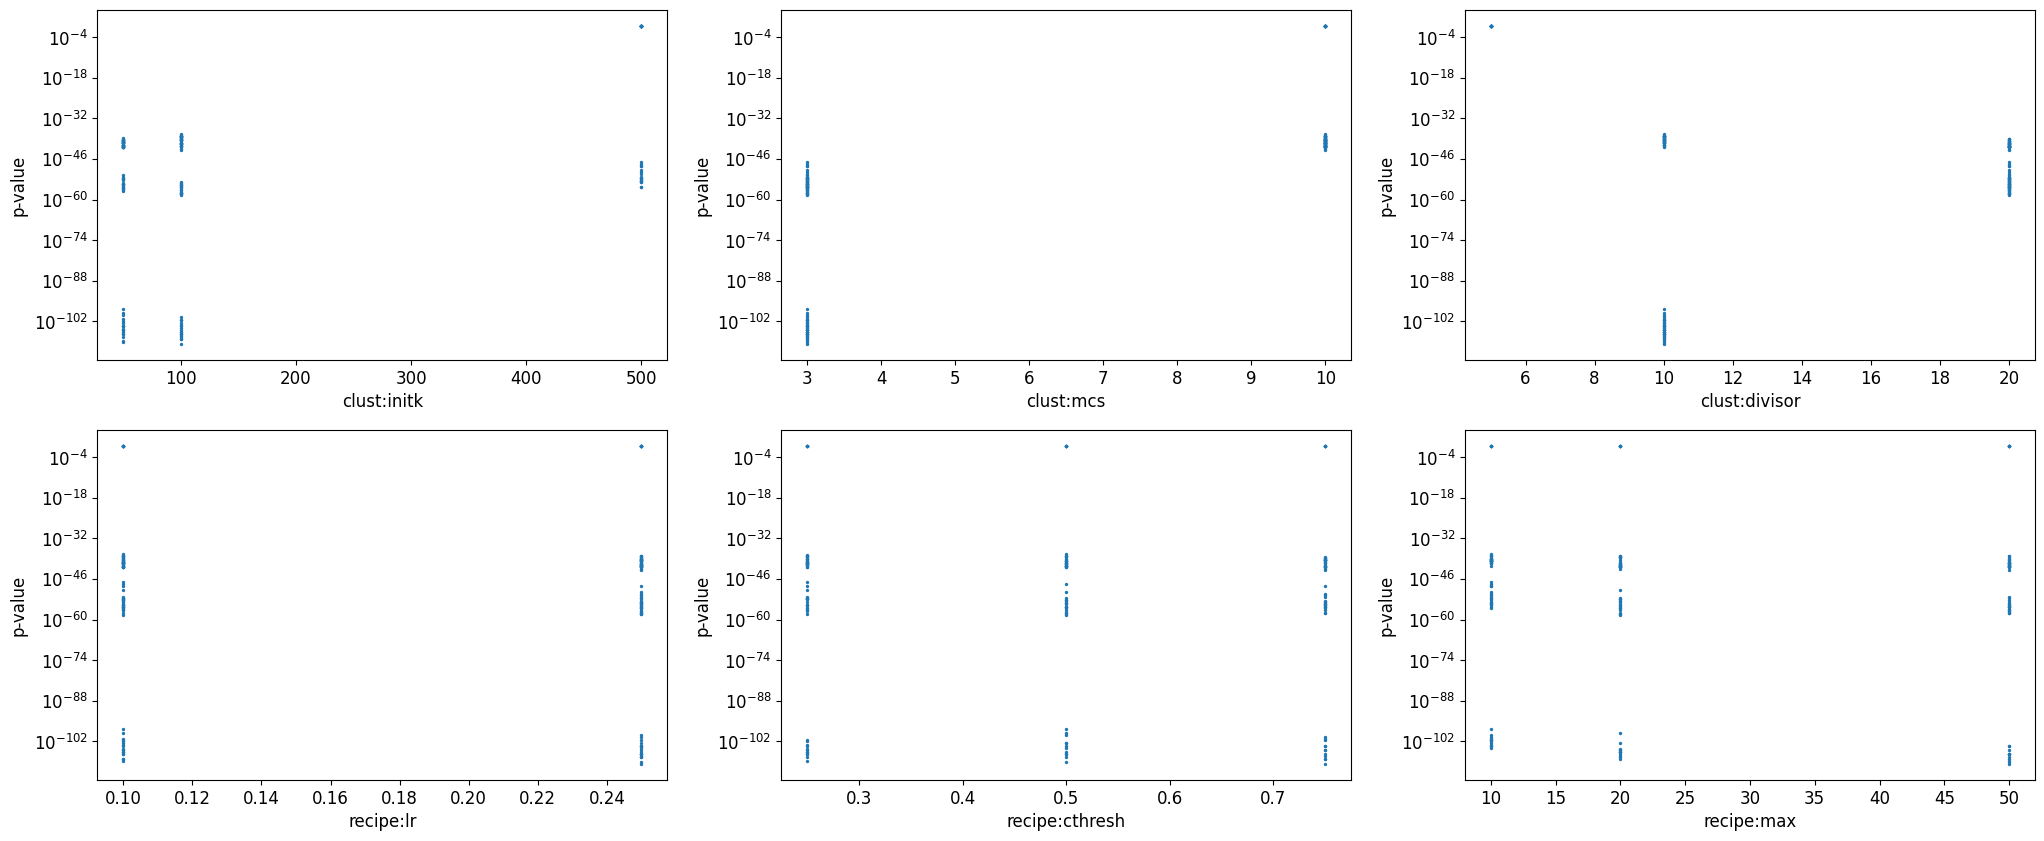

In [ ]:
# plot linear relationship between each parameter and p-value
fig,ax = plt.subplots(2,3, figsize=(25,10))
plt.rcParams.update({'font.size': 12})

for i, param in enumerate(["clust:initk", "clust:mcs", "clust:divisor", "recipe:lr", "recipe:cthresh", "recipe:max"]):
    ax_row = i // 3
    ax_col = i % 3
    ax[ax_row, ax_col].scatter(ps_results[param], ps_results["pval"],s=2)
    ax[ax_row, ax_col].set_xlabel(param)
    ax[ax_row, ax_col].set_ylabel("p-value")
    # -log10 p value for y axis
    ax[ax_row, ax_col].set_yscale("log")
plt.show()

# everything with initk = 1000 timed out


In [91]:
# get results with specific parameter values, -1 means it can be flexible
def get_results(initk=-1, mcs=-1, divisor=-1, lr=-1, cthresh=-1, max=-1):
    results = []
    for f in sorted(ps_stats):
        name, params = parse_stats_name_params(f)
        if (initk == -1 or params[0] == initk) and (mcs == -1 or params[1] == mcs) and (divisor == -1 or params[2] == divisor) and (lr == -1 or params[3] == lr) and (cthresh == -1 or params[4] == cthresh) and (max == -1 or params[5] == max):
            stat_pkg = parse_stats_file(f)
            results.append([name, *params, stat_pkg[0]])#, stat_pkg[1]])
    return pd.DataFrame(results, columns=["Name", "clust:initk", "clust:mcs", "clust:divisor", "recipe:lr", "recipe:cthresh", "recipe:max", "pval"])#, "tstat"])

In [96]:
config

{'run_name': 'ps',
 'work_dir': 'results/p_damicornis/20241219-paramSweep',
 'sequence_path': '/mnt/ceph/users/ssledzieski/philharmonic/p_damicornis/pdam_proteins.fasta',
 'go_filter_path': './code/assets/go_filter.txt',
 'use_llm': True,
 'seed': 6191998,
 'hmmscan': {'path': 'hmmscan', 'threads': 32},
 'dscript': {'path': 'dscript',
  'n_pairs': -1,
  'model': 'samsl/dscript_human_v1',
  'device': 0},
 'dsd': {'path': 'fastdsd', 't': 0.5, 'confidence': True},
 'clustering': {'init_k': [50, 100, 500, 1000],
  'min_cluster_size': [3, 10],
  'cluster_divisor': [5, 10, 20],
  'sparsity_thresh': '1e-5'},
 'recipe': {'lr': [0.1, 0.25],
  'cthresh': [0.25, 0.5, 0.75],
  'max_proteins': [10, 20, 50],
  'metric': 'degree'},
 'langchain': {'model': 'gpt-4o'}}

In [105]:
get_results(initk=50, mcs=3, divisor=-1)

,Name,clust:initk,clust:mcs,clust:divisor,recipe:lr,recipe:cthresh,recipe:max,pval
0,initk:50_mcs:3_cd:10_lr:0.1_cthresh:0.25_max:10,50,3,10,0.10,0.25,10,1.534000e-102
1,initk:50_mcs:3_cd:10_lr:0.1_cthresh:0.25_max:20,50,3,10,0.10,0.25,20,2.920000e-105
2,initk:50_mcs:3_cd:10_lr:0.1_cthresh:0.25_max:50,50,3,10,0.10,0.25,50,1.699000e-109
3,initk:50_mcs:3_cd:10_lr:0.1_cthresh:0.5_max:10,50,3,10,0.10,0.50,10,1.759000e-98
4,initk:50_mcs:3_cd:10_lr:0.1_cthresh:0.5_max:20,50,3,10,0.10,0.50,20,6.226000e-100
5,initk:50_mcs:3_cd:10_lr:0.1_cthresh:0.5_max:50,50,3,10,0.10,0.50,50,3.305000e-107
6,initk:50_mcs:3_cd:10_lr:0.1_cthresh:0.75_max:10,50,3,10,0.10,0.75,10,8.516000e-102
7,initk:50_mcs:3_cd:10_lr:0.1_cthresh:0.75_max:20,50,3,10,0.10,0.75,20,1.128000e-105
8,initk:50_mcs:3_cd:10_lr:0.1_cthresh:0.75_max:50,50,3,10,0.10,0.75,50,3.203000e-107
9,initk:50_mcs:3_cd:10_lr:0.25_cthresh:0.25_max:10,50,3,10,0.25,0.25,10,2.485000e-104
